<a href="https://colab.research.google.com/github/zhe0/prac/blob/main/pyspark_gbtOnCateAndNum_and_clusteringOnNumAndVector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=7ebfa9e46d834d65f0a94ac2808ba75ed69e8bbe742a9373bda3e30cce59c420
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.sql import SparkSession
import time
import pandas as pd
from sklearn.model_selection import train_test_split

In [ ]:
# Valid log levels include: ALL, DEBUG, ERROR, FATAL, INFO, OFF, TRACE, WARN
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()
spark.sparkContext.setLogLevel("ALL")
spark

In [ ]:
# example: vector as a var in inputs
# data = [
#     (1.0, Vectors.dense(3.0, 4.0), "a"),
#     (2.0, Vectors.dense(6.0, 7.0), "b"),
#     (3.0, Vectors.dense(9.0, 10.0), "c"),
#     (4.0, Vectors.dense(1.0, 2.0), "a"),
#     (5.0, Vectors.dense(4.0, 5.0), "b")
# ]
# df = spark.createDataFrame(data, ["feature1", "vector", "category"])
# category_indexer = StringIndexer(inputCol="category", outputCol="category_index")

#org: name	main_category	sub_category	image	link	ratings	no_of_ratings	discount_price	actual_price
#sel: name main_category sub_category ratings no_of_ratings discount_price actual_price

# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print("Silhouette with squared euclidean distance = " + str(silhouette))
# predictions.show()

Silhouette with squared euclidean distance = 0.6120640643838152
+--------+----------+--------+--------------+--------------+----------+
|feature1|    vector|category|category_index|      features|prediction|
+--------+----------+--------+--------------+--------------+----------+
|     1.0| [3.0,4.0]|       a|           0.0| [1.0,3.0,4.0]|         1|
|     2.0| [6.0,7.0]|       b|           1.0| [2.0,6.0,7.0]|         0|
|     3.0|[9.0,10.0]|       c|           2.0|[3.0,9.0,10.0]|         0|
|     4.0| [1.0,2.0]|       a|           0.0| [4.0,1.0,2.0]|         1|
|     5.0| [4.0,5.0]|       b|           1.0| [5.0,4.0,5.0]|         1|
+--------+----------+--------+--------------+--------------+----------+



### 寵物領養率的數據分析

* PetID - Unique hash ID of pet profile
* AdoptionSpeed - Categorical speed of adoption. Lower is faster. This is the value to predict. See below section for more info.
* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to BreedLabels dictionary)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to BreedLabels dictionary)
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to ColorLabels dictionary)
* Color2 - Color 2 of pet (Refer to ColorLabels dictionary)
* Color3 - Color 3 of pet (Refer to ColorLabels dictionary)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to StateLabels dictionary)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* PhotoAmt - Total uploaded photos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.


In [ ]:
# 下載github必須記得要把repo開public
# url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{pyfile}"
# !wget --no-cache --backups=1 {url}
# !wget https://github.com/zhe0/prac/raw/main/petfinder_for_tutorial.zip

!gdown 16_Ql6zKjm8ugpzh-_9zsP2rKAN5BjG-c
!unzip -o /content/petfinder_for_tutorial.zip

In [ ]:
# 貌似要做一定的資料處理...?  NAN 空格 資料行混了
# 是我自行上傳的，資料比較多
label_col = 'AdoptionSpeed'
# data = pd.read_csv('./train.csv', index_col=0) #download from kaggle

dataset_path='/content/petfinder_for_tutorial'
data = pd.read_csv(f'{dataset_path}/train.csv', index_col=0)
data

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,Images
0,2,Yumi Hamasaki,4,292,265,2,1,5,7,2,...,1,0,41326,bcc4e1b9557a8b3aaf545ea8e6e86991,0,I rescued Yumi Hamasaki at a food stall far aw...,7d7a39d71,3.0,0,images/7d7a39d71-1.jpg
1,2,Nene/ Kimie,12,285,0,2,5,6,7,2,...,1,0,41326,f0450bf0efe0fa3ff9321d0b827b1237,0,Has adopted by a friend with new pet name Kimie,0e107c82f,3.0,0,images/0e107c82f-1.jpg
2,2,Mattie,12,266,0,2,1,7,0,2,...,1,0,41401,9b52af6d48a4521fd01d4028eb5879a3,0,I rescued Mattie with a broken leg. After surg...,1a8fd6707,5.0,0,images/1a8fd6707-1.jpg
3,1,NaN,1,189,307,2,1,2,0,2,...,1,0,41401,88da1210e021a5cf43480b074778f3bc,0,She born on 30 September . I really hope the a...,bca8b44ae,3.0,0,images/bca8b44ae-1.jpg
4,2,Coco,6,276,285,2,2,4,7,2,...,1,100,41326,227d7b1bcfaffb5f9882bf57b5ee8fab,0,Calico Tame and easy going Diet RC Kitten Supp...,2def67952,1.0,0,images/2def67952-1.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2,Brownieâ¥,12,266,0,2,1,2,0,1,...,1,0,41327,1989cfa5f11b748338b6b639a810e186,0,This is BROWNIE. Color: Black & Brown. Breed: ...,aeffc6dfd,1.0,1,images/aeffc6dfd-1.jpg
596,2,Tabby &tammy,3,243,0,2,2,3,4,2,...,2,0,41401,1984caa688fee1576d4b783ee6f44501,0,"This 2little kitten,s are brother n sister,pot...",a4f6acdb6,0.0,1,images/a4f6acdb6-1.jpg
597,2,Melon,6,266,0,2,4,7,0,1,...,1,0,41401,a6dcfa5b8d8b328c5f2292a3b168f197,0,This kitty was rescued from the street.But she...,38063ee14,2.0,1,images/38063ee14-1.jpg
598,1,5 New Born Puppies,0,307,307,3,2,7,0,1,...,5,5,41326,d6b828d594ddeb7ddbb6c0b9e75f8145,0,Very small puppies,d3faf6a0e,0.0,1,images/d3faf6a0e-1.jpg


In [ ]:
# split dataset
# test_data = pd.read_csv('./test.csv', index_col=0) #沒有AdoptionSpeed
train_data,test_data=train_test_split(data,test_size=0.1)
print(len(train_data),len(test_data))
train_data.head()

# 我們預計要predict AdoptionSpeed的可能值，越短越快
train_data[label_col].unique()

540 60


array([1, 0])

### preparing dataset
* cast to categorical or standardize of scalar var

In [ ]:
#remove not help columns: RescuerID, Images, PetID
print(train_data.columns)
rm=['Name','RescuerID','PetID','Images','Description']
tra=train_data[[i for i in train_data.columns if not i in rm]]
test=test_data[[i for i in test_data.columns if not i in rm]]
print('col names',tra.columns)

print('--------------'*5)
print('cast data into cate or standard')
tra_df=spark.createDataFrame(list(tra.itertuples(index=False, name=None)), tra.columns.tolist())
test_df=spark.createDataFrame(list(test.itertuples(index=False, name=None)), test.columns.tolist())

# Define cols should cast or not
cate=['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
      'FurLength','Vaccinated','Dewormed','Sterilized','Health']
scale_cols=[i for i in tra_df.columns if (not i == label_col) and i not in cate]

# Define the pipeline stages
stages = []

# Set some cols need to be cate or scaler
cate=['Breed1','Breed2','Gender','Color1','Color2','Color3','MaturitySize',
      'FurLength','Vaccinated','Dewormed','Sterilized','Health']
cate_idx=[i+'_idx' for i in cate]
print('scale_cols+cate_idx: ',scale_cols+cate_idx)

stages += [StringIndexer(inputCols=cate, outputCols=cate_idx).setHandleInvalid("keep")]
stages += [VectorAssembler(inputCols=scale_cols+cate_idx ,outputCol="features")]
stages += [StandardScaler(inputCol="features", outputCol="scaled_features",withStd=True,withMean=False)]
stages

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed',
       'Images'],
      dtype='object')
col names Index(['Type', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'VideoAmt',
       'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')
----------------------------------------------------------------------
cast data into cate or standard
scale_cols+cate_idx:  ['Type', 'Age', 'Quantity', 'Fee', 'State', 'VideoAmt', 'PhotoAmt', 'Breed1_idx', 'Breed2_idx', 'Gender_idx', 'Color1_idx', 'Color2_idx', 'Color3_idx', 'MaturitySize_idx', 'FurLength_idx', 'Vaccinated_idx', 'Dewormed_idx', 'Sterilized_idx', 'Health_idx']


[StringIndexer_2f8f0d3ec9ef,
 VectorAssembler_40caea7a8b71,
 StandardScaler_08beb649616a]

### classification task on ensemble struc


In [ ]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [ ]:
# Create the individual models
# lr = LogisticRegression(labelCol=label_col,featuresCol="scaled_features")
# rf = RandomForestClassifier(labelCol=label_col,featuresCol="scaled_features")
gbt = GBTClassifier(labelCol=label_col,featuresCol="scaled_features")

# Create a pipeline for single model. can not concate each model in one pipe
stages += [gbt]
print('stages: ',stages)
pipeline = Pipeline(stages=stages)

stages:  [StringIndexer_2f8f0d3ec9ef, VectorAssembler_40caea7a8b71, StandardScaler_08beb649616a, GBTClassifier_96bb6ad43615]


In [ ]:
#numFolds of cross valid
numFolds=5

# Create a parameter grid for each model
grid = ParamGridBuilder().addGrid(gbt.maxIter, [5, 50]) \
    .addGrid(gbt.maxDepth, [5, 30]).build()


# evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol='prediction', metricName="accuracy")
# evaluator = BinaryClassificationEvaluator()

# Create a cross validator for each model
# parallelism=4 因為 2 cores * 2 threads
p={'estimator':pipeline, 'evaluator':evaluator, 'estimatorParamMaps':grid, 'numFolds':numFolds, 'parallelism':4}
cv = CrossValidator(**p)
cv.params

[Param(parent='CrossValidator_6b1750017738', name='collectSubModels', doc='Param for whether to collect a list of sub-models trained during tuning. If set to false, then only the single best sub-model will be available after fitting. If set to true, then all sub-models will be available. Warning: For large models, collecting all sub-models can cause OOMs on the Spark driver.'),
 Param(parent='CrossValidator_6b1750017738', name='estimator', doc='estimator to be cross-validated'),
 Param(parent='CrossValidator_6b1750017738', name='estimatorParamMaps', doc='estimator param maps'),
 Param(parent='CrossValidator_6b1750017738', name='evaluator', doc='evaluator used to select hyper-parameters that maximize the validator metric'),
 Param(parent='CrossValidator_6b1750017738', name='foldCol', doc="Param for the column name of user specified fold number. Once this is specified, :py:class:`CrossValidator` won't do random k-fold split. Note that this column should be integer type with range [0, num

### fit 之前兩處要注意
1. 如果計算量太大，會導致底層Py4JJavaError錯誤，請弄小一點的grid
2. 出現下面錯誤，代表可能使用多個模組在同一個pipeline，或是不小心多加一次模組在pipe
* 導致pipe中產生evaluator的prediction重複了
 IllegalArgumentException: requirement failed: Column prediction already exists.
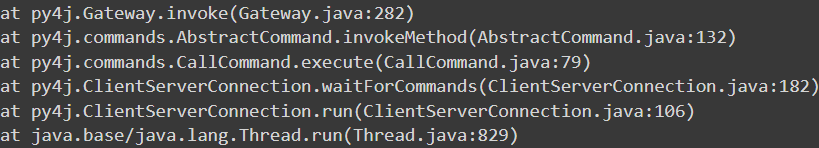

In [ ]:
# Train the models
cv_model = cv.fit(tra_df)

# Get the best model
best_model = cv_model.bestModel
best_model

PipelineModel_65ea104a04b0

In [ ]:
gb_params = cv_model.bestModel.stages[-1].extractParamMap()
print("Best GBTClassifier hyperparameters:")
for key, value in gb_params.items():
    print(f"{key}: {value}")

Best GBTClassifier hyperparameters:
GBTClassifier_96bb6ad43615__cacheNodeIds: False
GBTClassifier_96bb6ad43615__checkpointInterval: 10
GBTClassifier_96bb6ad43615__featureSubsetStrategy: all
GBTClassifier_96bb6ad43615__featuresCol: scaled_features
GBTClassifier_96bb6ad43615__impurity: variance
GBTClassifier_96bb6ad43615__labelCol: AdoptionSpeed
GBTClassifier_96bb6ad43615__leafCol: 
GBTClassifier_96bb6ad43615__lossType: logistic
GBTClassifier_96bb6ad43615__maxBins: 32
GBTClassifier_96bb6ad43615__maxDepth: 5
GBTClassifier_96bb6ad43615__maxIter: 5
GBTClassifier_96bb6ad43615__maxMemoryInMB: 256
GBTClassifier_96bb6ad43615__minInfoGain: 0.0
GBTClassifier_96bb6ad43615__minInstancesPerNode: 1
GBTClassifier_96bb6ad43615__minWeightFractionPerNode: 0.0
GBTClassifier_96bb6ad43615__predictionCol: prediction
GBTClassifier_96bb6ad43615__probabilityCol: probability
GBTClassifier_96bb6ad43615__rawPredictionCol: rawPrediction
GBTClassifier_96bb6ad43615__seed: 7089005679527190930
GBTClassifier_96bb6ad4361

In [ ]:
# Get feature importance
print("Feature Importance: ", best_model.featureImportances)

In [ ]:
# Make predictions
predictions = best_model.transform(test_df)

accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of gradient boost: {accuracy}")

Accuracy of gradient boost: 0.6666666666666666


In [ ]:
predictions.select(label_col, "prediction").show()

+-------------+----------+
|AdoptionSpeed|prediction|
+-------------+----------+
|            0|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       1.0|
|            1|       0.0|
|            0|       0.0|
|            1|       0.0|
|            0|       0.0|
|            1|       1.0|
|            1|       1.0|
|            0|       1.0|
|            0|       1.0|
|            0|       1.0|
|            1|       1.0|
|            0|       0.0|
|            1|       1.0|
|            0|       1.0|
|            0|       1.0|
|            0|       0.0|
+-------------+----------+
only showing top 20 rows



### 預計使用  silhouette coefficient 來評估分群結果好壞
步驟:
* 1.每個點在判定哪個cluster時? 以a群比較剩下群(bcd...)的平均距離
* 2.假設有10群，loop每個群，並計算一個silhouette分數
* 3.silhouette越大代表越是隸屬這個群
* 4.數學意義是其他群的平均距離 減去 a群的平均距離

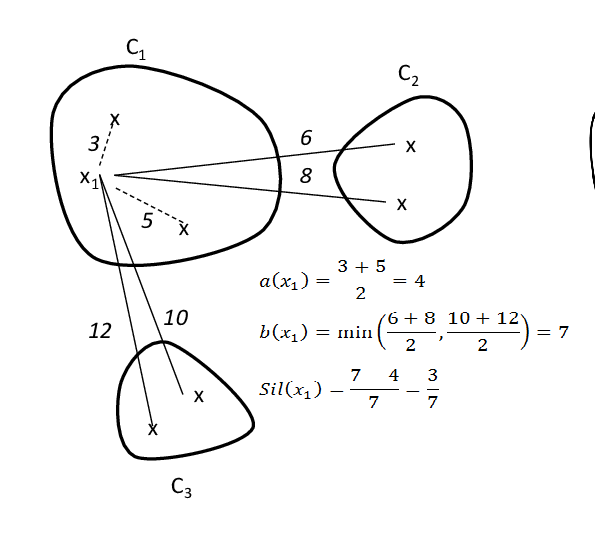

In [ ]:
st=time.time()
kmeans = KMeans(k=2, featuresCol="features")

pipeline = Pipeline(stages=[ category_indexer, assembler, kmeans])
model = pipeline.fit(tra_df)

predictions = model.transform(tra_df)
print('exec time: ',(time.time()-st))
predictions.show()

exec time:  22.96891760826111
+---+------+------+------+------+------+------+------------+---------+----------+--------+----------+------+--------+---+-----+--------+--------+-------------+-------+-------+-------+-------+-------+-------+-------------+----------+-----------+---------+-----------+-------+--------------------+----------+
|Age|Breed1|Breed2|Gender|Color1|Color2|Color3|MaturitySize|FurLength|Vaccinated|Dewormed|Sterilized|Health|Quantity|Fee|State|VideoAmt|PhotoAmt|AdoptionSpeed|Breed1_|Breed2_|Gender_|Color1_|Color2_|Color3_|MaturitySize_|FurLength_|Vaccinated_|Dewormed_|Sterilized_|Health_|            features|prediction|
+---+------+------+------+------+------+------+------------+---------+----------+--------+----------+------+--------+---+-----+--------+--------+-------------+-------+-------+-------+-------+-------+-------+-------------+----------+-----------+---------+-----------+-------+--------------------+----------+
|  2|   307|     0|     2|     1|     0|     0|  

to predict test dataset

In [ ]:
# training dataset performance
evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.7933820625992595


In [ ]:
assembler = VectorAssembler(inputCols=test_df.columns,outputCol="features")

kmeans = KMeans(k=2, featuresCol="features")

pipeline = Pipeline(stages=[ category_indexer, assembler, kmeans])
model = pipeline.fit(test_df)

predictions = model.transform(test_df)
predictions.show()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

+---+------+------+------+------+------+------+------------+---------+----------+--------+----------+------+--------+---+-----+--------+--------+-------------+-------+-------+-------+-------+-------+-------+-------------+----------+-----------+---------+-----------+-------+--------------------+----------+
|Age|Breed1|Breed2|Gender|Color1|Color2|Color3|MaturitySize|FurLength|Vaccinated|Dewormed|Sterilized|Health|Quantity|Fee|State|VideoAmt|PhotoAmt|AdoptionSpeed|Breed1_|Breed2_|Gender_|Color1_|Color2_|Color3_|MaturitySize_|FurLength_|Vaccinated_|Dewormed_|Sterilized_|Health_|            features|prediction|
+---+------+------+------+------+------+------+------------+---------+----------+--------+----------+------+--------+---+-----+--------+--------+-------------+-------+-------+-------+-------+-------+-------+-------------+----------+-----------+---------+-----------+-------+--------------------+----------+
| 60|   179|     0|     2|     7|     0|     0|           1|        2|         